<a href="https://colab.research.google.com/github/ccxlxy/Coding/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 挂载google硬盘
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 安装kaggle库
!pip install kaggle

In [ ]:
!pwd

/content


In [ ]:
import json
token = {"username":"ccxlxy","key":"5ed13b258ad77a30e506bfd00ef579ed"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)

In [ ]:
# 创建一个文件夹保存kaggle用户名和秘钥
!mkdir -p ~/.kaggle

In [ ]:
!ls

drive  kaggle.json  sample_data


In [ ]:
# 复制该json文件到刚才新建的指定路径下
!cp /content/kaggle.json ~/.kaggle/

In [ ]:
# 修改json文件权限, 确保后续操作能正常进行
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 指定kaggle数据集保存的位置，kaggle数据集将保存在/content路径下
!kaggle config set -n path -v /content

- path is now set to: /content


In [ ]:
# 通过kaggle的API下载数据集
!kaggle datasets download -d rahulsah06/titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import os
os.chdir("datasets/rahulsah06/titanic")
!unzip titanic.zip

parameters={
*      "criterion":("gini","entropy"),
*     "splitter":("best","random"),
*      "max_depth":[*range(1,10)],
*      "min_samples_split":[*range(1,10)],
*      "min_sample_leaf":[*range(1,10)],
*      "min_weight_fraction_leaf":None,# 权重问题
*      "max_features":(5,0.5,"auto","sqrt","log2","None"),
*      "random_state":(0,10,20,30),
*      "max_leaf_nodes":(*range(5,10)),
*      "min_impurity_decrease":(*range(0,0.1,0.01)),
*      "class_weight": dict类型
*      "presort":(True,False)
}

In [ ]:
# 导入所需要的库
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # 活不活，二分类问题
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score # 交叉验证得分
import matplotlib.pyplot as plt

In [ ]:
# 导入数据集，探索数据
data=pd.read_csv("/content/datasets/rahulsah06/titanic/train.csv",index_col=0)

In [ ]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [ ]:
# 对数据集进行预处理
# 缺失值处理+无效feature删除
data.drop(["Name","Ticket","Cabin"],inplace=True,axis=1)

data["Age"]=data["Age"].fillna(data["Age"].mean()) # 用均值填充年龄缺失值

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 102.6+ KB


In [ ]:
data=data.dropna()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


In [ ]:
# 数值型变量处理
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [ ]:
data["Sex"]=(data["Sex"]=="male").astype("int") # 将二分类变量转换为数值型变量转换为0，1型

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,S
2,1,1,0,38.0,1,0,71.2833,C
3,1,3,0,26.0,0,0,7.9250,S
4,1,1,0,35.0,1,0,53.1000,S
5,0,3,1,35.0,0,0,8.0500,S


In [ ]:
# 将多分类变量转换为数值型变量
labels=data["Embarked"].unique().tolist()
labels

['S', 'C', 'Q']

In [ ]:
data["Embarked"]=data["Embarked"].apply(lambda x:labels.index(x))

ValueError: ignored

In [ ]:
data.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0
2,1,1,0,38.0,1,0,71.2833,1
3,1,3,0,26.0,0,0,7.9250,0


In [ ]:
# 提取标签和特侦矩阵，分测试集训练集
X=data.iloc[:,data.columns!="Survived"] # iloc[]通过切片的形式选取df的行（记录）
Y=data.iloc[:,data.columns=="Survived"]
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,1,22.0,1,0,7.2500,0
2,1,0,38.0,1,0,71.2833,1
3,3,0,26.0,0,0,7.9250,0
4,1,0,35.0,1,0,53.1000,0
5,3,1,35.0,0,0,8.0500,0


In [ ]:
Y.head()

,Survived
PassengerId,
1,0
2,1
3,1
4,1
5,0


In [ ]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y,test_size=0.3)

Xtrain.head() # 索引混乱

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
865,2,1,24.0,0,0,13.0000,0
778,3,0,5.0,0,0,12.4750,0
91,3,1,29.0,0,0,8.0500,0
228,3,1,20.5,0,0,7.2500,0
653,3,1,21.0,0,0,8.4333,0


In [ ]:
# 注意：有索引作为id的，在进行随机划分数据集后要进行索引重排，修正索引
for i in [Xtrain,Xtest,Ytrain,Ytest]:
  i.index=range(i.shape[0]) # 通过循环修改4个数据集，通过shape[0]获取个数

Xtrain.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,2,1,24.0,0,0,13.0000,0
1,3,0,5.0,0,0,12.4750,0
2,3,1,29.0,0,0,8.0500,0
3,3,1,20.5,0,0,7.2500,0
4,3,1,21.0,0,0,8.4333,0


In [ ]:
# 导入模型，跑一下结果
clf=DecisionTreeClassifier(random_state=30) # 其他参数暂时不设置，粗略跑一下结果
clf=clf.fit(Xtrain,Ytrain)
score=clf.score(Xtest,Ytest)
score

0.7677902621722846

In [ ]:
score=cross_val_score(clf,X,Y,cv=10).mean() #10折交叉验证得分取平均
score

0.7817798774259448

0.8200331971399386


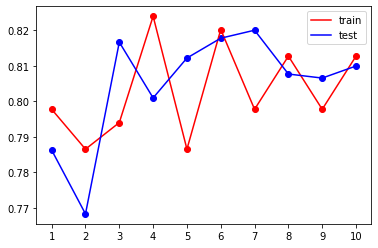

In [ ]:
# 在不同的max_depth下观察模型的拟合情况
train=[]
test=[]
for i in range(10):
  clf=DecisionTreeClassifier(max_depth=i+1,criterion="entropy",random_state=20) # 其他参数暂时不设置，粗略跑一下结果
  clf=clf.fit(Xtrain,Ytrain)
  score1=clf.score(Xtest,Ytest)
  score2=cross_val_score(clf,X,Y,cv=10).mean()
  train.append(score1)
  test.append(score2)

print(max(test)) # 在测试集上的最高分
fig,ax=plt.subplots()
# 关于max_depth取值与score的对应线
ax.scatter(range(1,11),train,color="red") # 注意是（1，11）
ax.plot(range(1,11),train,color="red",label="train")
ax.scatter(range(1,11),test,color="blue") 
ax.plot(range(1,11),test,color="blue",label="test")
ax.set_xticks(range(1,11)) # 修改刻度
plt.legend()
plt.show()

# 在训练集和测试集上情况越接近越好，越高越高，防止欠拟合，防止过拟合

In [ ]:
# 用网格搜索调整参数
import numpy as np
parameters={"splitter":("random","best"),
      "criterion":("gini","entropy"),
      "max_depth":[*range(1,10)],
      "min_samples_leaf":[*range(1,20,5)],
      "min_impurity_decrease":[*np.linspace(0,0.5,20)] # 等差数列
      }
clf=DecisionTreeClassifier(random_state=20)
GS=GridSearchCV(clf,parameters,cv=10) # 10折网格搜索
GS.fit(Xtrain,Ytrain)


0.8248079877112134

In [ ]:
GS.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 6,
 'splitter': 'best'}

In [ ]:
GS.best_score_

0.8248079877112134